# Example of using TVB importers from within the REST client API.
## TVB REST server is part of tvb-framework release. If you want to run this example you will have to start a REST server or you should have access to a public TVB REST server.

Here, we upload two independent datatypes: a connectivity and a surface from ZIP formats.

Then, we upload a region mapping that depends on both connectivity and surface to exist in TVB storage.

Note: TVB REST server is part of the tvb-framework release. If you want to run this example, you will have to start a REST server or you should have access to a public TVB REST server.

*WARNING*: Your jupyter notebook server probably runs on localhost:8888, which is used by TVBClient. You should run jupyter on a different port (e.g. jupyter notebook --port 9999).

In [ ]:
import os
import time

import tvb_data
from keycloak import KeycloakOpenID
from tvb.core.entities.model.model_operation import STATUS_ERROR, STATUS_CANCELED, STATUS_FINISHED
from tvb.interfaces.rest.client.tvb_client import TVBClient

In [ ]:
def compute_tvb_data_path(folder, filename):
    return os.path.join(os.path.dirname(tvb_data.__file__), folder, filename)

def monitor_operation(tvb_client, operation_gid):
    while True:
        status = tvb_client.get_operation_status(operation_gid)
        if status in [STATUS_FINISHED, STATUS_CANCELED, STATUS_ERROR]:
            break
        print("Current operation GID {} => STATUS {}".format(operation_gid, status))
        time.sleep(5)
    print("Operation {} has finished with status: {}".format(operation_gid, status))

In [ ]:
# Enter the URL to your REST server
tvb_client = TVBClient("http://localhost:9090")

keycloak_instance = KeycloakOpenID("https://keycloak.codemart.ro/auth/", "TVB", "tvb-tests")

tvb_client._update_token(keycloak_instance.token("tvb_user", "pass"))
tvb_client.is_data_encrypted = tvb_client.datatype_api.is_data_encrypted()

In [ ]:
# Requesting projects for the logged user
projects_of_user = tvb_client.get_project_list()
default_project = projects_of_user[0]
default_project_gid = default_project.gid
default_project.name

## Launch operations to import a Connectivity, a Surface and a RegionMapping

In [ ]:
from tvb.adapters.uploaders.zip_connectivity_importer import ZIPConnectivityImporterModel, ZIPConnectivityImporter

# Importing a connectivity from ZIP
zip_connectivity_importer_model = ZIPConnectivityImporterModel()
zip_connectivity_importer_model.uploaded = compute_tvb_data_path('connectivity', 'connectivity_96.zip')
zip_connectivity_importer_model.normalization = 'region'
operation_gid = tvb_client.launch_operation(default_project_gid, ZIPConnectivityImporter,
                                                         zip_connectivity_importer_model)

monitor_operation(tvb_client, operation_gid)

# Get the result of connectivity import
connectivity_dto = tvb_client.get_operation_results(operation_gid)[0]
connectivity_gid = connectivity_dto.gid

connectivity_gid

In [ ]:
from tvb.adapters.uploaders.zip_surface_importer import ZIPSurfaceImporterModel, ZIPSurfaceImporter
from tvb.datatypes.surfaces import SurfaceTypesEnum

# Importing a surface from ZIP
zip_surface_importer_model = ZIPSurfaceImporterModel()
zip_surface_importer_model.uploaded = compute_tvb_data_path('surfaceData', 'cortex_16384.zip')
zip_surface_importer_model.surface_type = SurfaceTypesEnum.CORTICAL_SURFACE
zip_surface_importer_model.should_center = False

operation_gid = tvb_client.launch_operation(default_project_gid, ZIPSurfaceImporter, zip_surface_importer_model)
monitor_operation(tvb_client, operation_gid)

# Get the result of surface import
surface_dto = tvb_client.get_operation_results(operation_gid)[0]
surface_gid = surface_dto.gid

surface_gid

In [ ]:
from tvb.adapters.uploaders.region_mapping_importer import RegionMappingImporterModel, RegionMappingImporter

# Importing a region mapping
rm_importer_model = RegionMappingImporterModel()
rm_importer_model.mapping_file = compute_tvb_data_path('regionMapping', 'regionMapping_16k_76.txt')
rm_importer_model.connectivity = connectivity_dto.gid
rm_importer_model.surface = surface_gid

operation_gid = tvb_client.launch_operation(default_project_gid, RegionMappingImporter, rm_importer_model)
monitor_operation(tvb_client, operation_gid)

# Get the result of region mapping import
region_mapping_dto = tvb_client.get_operation_results(operation_gid)[0]
region_mapping_gid = region_mapping_dto.gid

region_mapping_gid

## Load the region mapping together with references information in 3 different ways


In [ ]:
# 1.Download and load the region mapping with all its references
region_mapping_complete = tvb_client.load_datatype_with_full_references(region_mapping_gid, os.getcwd())

"This region mapping is linked to a connectivity with GID={} and number_of_regions={}".format(
        region_mapping_complete.connectivity.gid, region_mapping_complete.connectivity.number_of_regions)

In [ ]:
# 2.Download and load the region mapping with only GIDs for its references
region_mapping_with_links = tvb_client.load_datatype_with_links(region_mapping_gid, os.getcwd())

"This region mapping is linked to a connectivity with GID={}".format(region_mapping_with_links.connectivity.gid)

In [ ]:
# 3.1.Only download the region mapping on client machine
region_mapping_path = tvb_client.retrieve_datatype(region_mapping_dto.gid, os.getcwd())
print(region_mapping_path)

# 3.2.Load the region mapping that was already downloaded on client machine
local_region_mapping_with_links = tvb_client.load_datatype_from_file(region_mapping_path)

"This region mapping is linked to a connectivity with GID={}".format(local_region_mapping_with_links.connectivity.gid)

## Launch operation to run a Degree Analyzer over the Connectivity

In [ ]:
from tvb.adapters.analyzers.bct_degree_adapters import Degree
from tvb.adapters.analyzers.bct_adapters import BaseBCTModel

# Prepare BCT model
bct_model = BaseBCTModel()
bct_model.connectivity = connectivity_gid

# Launch BCT
operation_gid = tvb_client.launch_operation(default_project_gid, Degree, bct_model)
monitor_operation(tvb_client, operation_gid)

# Get the result of BCT...")
bct_dto = tvb_client.get_operation_results(operation_gid)[0]

bct_dto.gid

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2024-08-11 23:36:39,437 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


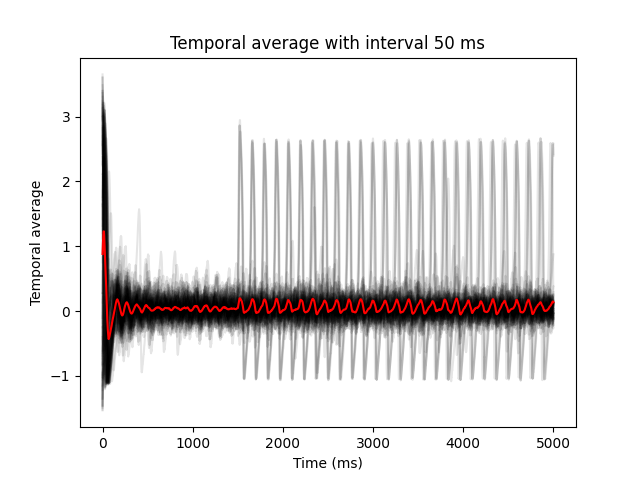

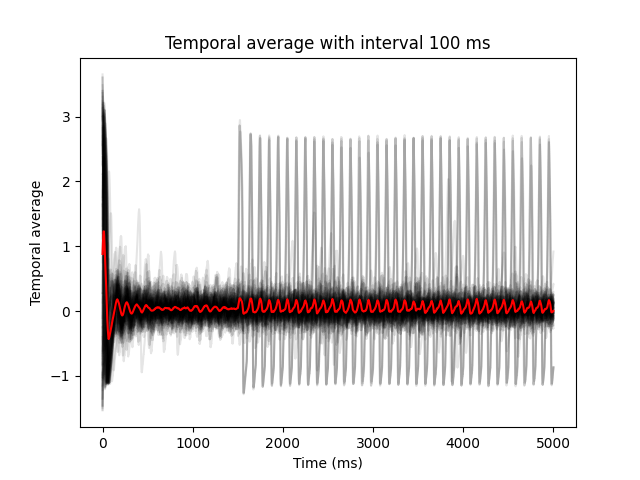

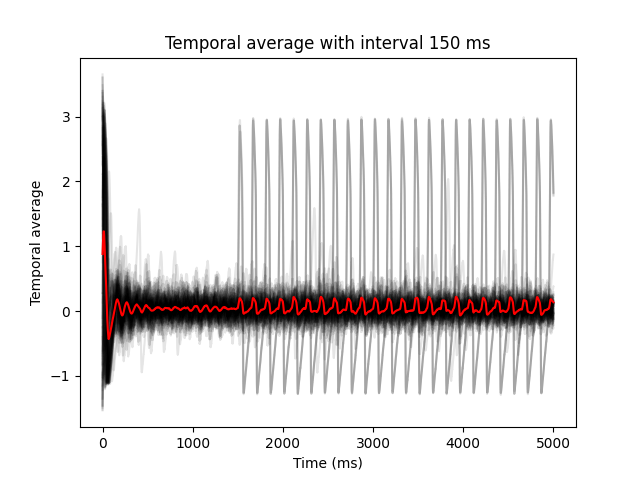

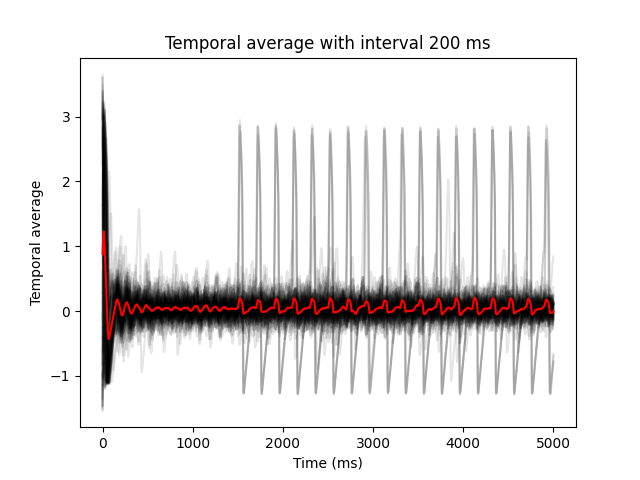

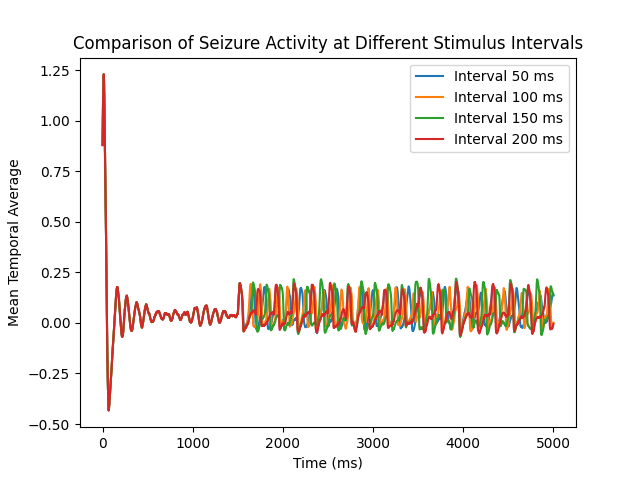